In [5]:
!pip install tensorflow
!pip install --upgrade protobuf
!python.exe -m pip install --upgrade pip


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------------------- ---------------- 1.0/1.8 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 4.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import os
from bs4 import BeautifulSoup

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [7]:
script_dir = os.getcwd()
file = os.path.join(script_dir, "..", "GameClient", "df_eneemr.csv")
df_origin = pd.read_csv(file)

In [17]:
df_model = df_origin

n_components = 0.95
random_state = 69

# smurf_score separat behandeln
# smurf_flag is basically y_test
num_df = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['smurf_flag'])
all_feautures = num_df.columns.tolist()
base_features = [col for col in all_feautures if col != 'smurf_score']
X = num_df
y = df_model['smurf_flag']

# Train-Test-Split
X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(X.index, y.index, test_size=0.2, random_state=random_state, stratify=y)
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]
y_train = y.loc[y_train_idx]
y_test = y.loc[y_test_idx]

# Testing der Splits
print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

# AutoEncoder Definition
def AutoEncoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

# AutoEncoder Training
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train[base_features])
X_test_s = scaler.transform(X_test[base_features])

pca_s = PCA(n_components=n_components)
X_train_p = pca_s.fit_transform(X_train_s)
X_test_p = pca_s.transform(X_test_s)

autoencoder = AutoEncoder(X_train_p.shape[1])
autoencoder.fit(X_train_p, X_train_p, epochs=30, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

train_pred = autoencoder.predict(X_train_p)
test_pred = autoencoder.predict(X_test_p)
train_mse = np.mean(np.square(X_train_p - train_pred), axis=1)
test_mse = np.mean(np.square(X_test_p - test_pred), axis=1)
threshold = np.percentile(train_mse, 90)

y_train_autoencoder = (train_mse > threshold).astype(int)
y_test_autoencoder = (test_mse > threshold).astype(int)


# Klassische Modelle
models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
}

results = {
    "AutoEncoder_Train": y_train_autoencoder,
    "AutoEncoder_Test": y_test_autoencoder
}

# Evaluation für AutoEncoder
print("\nAutoEncoder:")
print("Train:")
print(classification_report(y_train, y_train_autoencoder))
print("Test:")
print(classification_report(y_test, y_test_autoencoder))

for name, model in models.items():
    print(f"\n{name}:")

    # Pipeline inkl. Preprocessing
    preprocessor = ColumnTransformer([
        ('pca_pipeline', make_pipeline(StandardScaler(), PCA(n_components=n_components)), base_features)
    ], remainder='passthrough')

    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train)

    # Prediction
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Convert to binary anomaly labels (1=Anomalie)
    y_train_bin = (y_train_pred == -1).astype(int)
    y_test_bin = (y_test_pred == -1).astype(int)

    # Speichern für Majority Vote
    results[f"{name}_Train"] = y_train_bin
    results[f"{name}_Test"] = y_test_bin

    # Bewertung mit echten Labels
    print("Train:")
    print(classification_report(y_train, y_train_bin))
    print("Test:")
    print(classification_report(y_test, y_test_bin))

# Majority Vote
vote_train = sum([results[k] for k in results if k.endswith("_Train")]) >= 3
vote_test = sum([results[k] for k in results if k.endswith("_Test")]) >= 3

# Zusammenfassen
train_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Train"] for model in ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_train.index)
train_df['MajorityVote'] = vote_train.astype(int)
train_df['Dataset'] = 'Train'

test_df = pd.DataFrame({model.split('_')[0]: results[f"{model}_Test"] for model in ['IsolationForest', 'OneClassSVM', 'LocalOutlierFactor', 'AutoEncoder']}, index=X_test.index)
test_df['MajorityVote'] = vote_test.astype(int)
test_df['Dataset'] = 'Test'

comparison_df = pd.concat([train_df, test_df]).reset_index(drop=True)
comparison_df['TrueLabel'] = pd.concat([y_train, y_test]).reset_index(drop=True)

# Bewertung des Majority Vote
print("\nMajority Vote:")
print("Train:")
print(classification_report(y_train, train_df['MajorityVote']))
print("Test:")
print(classification_report(y_test, test_df['MajorityVote']))

smurf_flag
0    961
Name: count, dtype: int64
smurf_flag
0    768
Name: count, dtype: int64
smurf_flag
0    193
Name: count, dtype: int64
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

AutoEncoder:
Train:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       768
           1       0.00      0.00      0.00         0

    accuracy                           0.90       768
   macro avg       0.50      0.45      0.47       768
weighted avg       1.00      0.90      0.95       768

Test:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       193
           1       0.00      0.00      0.00         0

    accuracy                           0.93       193
   macro avg       0.50      0.46      0.48       193
weighted avg       1.00      0.93      0.96       193


IsolationForest:


C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

Train:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       768
           1       0.00      0.00      0.00         0

    accuracy                           0.97       768
   macro avg       0.50      0.48      0.49       768
weighted avg       1.00      0.97      0.98       768

Test:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       193
           1       0.00      0.00      0.00         0

    accuracy                           0.96       193
   macro avg       0.50      0.48      0.49       193
weighted avg       1.00      0.96      0.98       193


OneClassSVM:
Train:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       768
           1       0.00      0.00      0.00         0

    accuracy                           0.92       768
   macro avg       0.50      0.46      0.48       768
weighted avg       1.00      0.92      0

C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

Train:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       768
           1       0.00      0.00      0.00         0

    accuracy                           0.93       768
   macro avg       0.50      0.46      0.48       768
weighted avg       1.00      0.93      0.96       768

Test:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       193
           1       0.00      0.00      0.00         0

    accuracy                           0.93       193
   macro avg       0.50      0.47      0.48       193
weighted avg       1.00      0.93      0.97       193


Majority Vote:
Train:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       768
           1       0.00      0.00      0.00         0

    accuracy                           0.95       768
   macro avg       0.50      0.47      0.49       768
weighted avg       1.00      0.95     

C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\EnSei\Documents\GitHub\Research_CheatDetection_with_ML\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  

In [11]:
comparison_df.groupby("Dataset")["MajorityVote"].value_counts()

Dataset  MajorityVote
Test     0               174
         1                19
Train    0               731
         1                37
Name: count, dtype: int64

In [12]:
df_origin['riot_id'] = df_origin['riotIdGameName'].astype(str) + '#' + df_origin['riotIdTagline'].astype(str) + ' / ' + df_origin['gameId'].astype(str)

df_origin['MajorityVote'] = comparison_df['MajorityVote']
df_origin['MajorityVote']

0      0
1      0
2      0
3      0
4      0
      ..
956    0
957    0
958    0
959    0
960    0
Name: MajorityVote, Length: 961, dtype: int64

In [13]:
df_origin.groupby('MajorityVote')['smurf_category'].value_counts()

MajorityVote  smurf_category
0             normal            900
              likely_smurf        5
1             normal             56
Name: count, dtype: int64

In [14]:
smurf_names = df_origin.loc[df_origin['MajorityVote'] == True, 'riot_id'].unique()
smurf_names

array(['Philly Westside#MEGA / 7439359616',
       'DominaKočkoKluka#crnge / 7437630466', 'InToxx#666 / 7437576834',
       'Aunny#000 / 7426489292', 'Withice#ICE / 7439578465',
       'banana#coco / 7364655002', 'Myx#42069 / 7364655002',
       'Dr Aven#159 / 7417479649', 'xXthotslayerXx#69420 / 7432679847',
       'PhŒnixTheCreator#C MOI / 7438352716', 'Hopper#001 / 7438352716',
       'LemonMishap #EUW / 7438352716', 'shacOv9#1949 / 7438481037',
       'Titan#haha1 / 7437932115', 'SCELERAT MALSAIN#BUS / 7302171820',
       'VENOM THE KING#EUW / 7438953365', 'Zýdé#EUW / 7413699383',
       'Shueimang#EUW / 7439086597', '攻撃的で不安定#258 / 7416703754',
       'lenons#6222 / 7439410977', 'pawaq#EUW / 7439286779',
       '0wavestrave#0000 / 7439286779', 'Corntruthnade#EUW / 7439286779',
       'HiMyNameIsLars#EUW / 7439004000', 'Brofresco#6969 / 7439004000',
       'stein the#EUW / 7439634304', 'AsX Fairy#Tale / 7439634304',
       'LA BENDICION#1312 / 7439530376', 'EyeSeeYou#DS5 / 739838880

In [15]:
test = df_origin[df_origin['riotIdGameName'] == "Diffdoff2"]
test["smurf_flag"]

Series([], Name: smurf_flag, dtype: int64)

In [16]:
test2 = df_origin[df_origin['smurf_flag']==1]
test2['riot_id']

Series([], Name: riot_id, dtype: object)

In [15]:
'''all_results = []

def scrape_match_info(match_id, target_name, region='euw'):
    url = f"https://www.leagueofgraphs.com/match/{region}/{match_id}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return None

    soup = BeautifulSoup(response.text, 'html.parser')
    players = soup.select('tr.playerRow')
    target_riot_id = target_name.strip().lower()

    queue_span = soup.select_one('th span.queueName')
    queue_name = queue_span.text.strip() if queue_span else 'Unknown'

    for player in players:
        left_td = player.select_one('td.text-left.summoner_column')
        right_td = player.select_one('td.text-right.summoner_column')
        kda_columns = player.select('td.kdaColumn')
        kda_divs = player.select('div.kda')

        for i, td in enumerate([left_td, right_td]):
            if td is None:
                continue

            name_div = td.select_one('div.name')
            if not name_div:
                continue

            full_name = name_div.text.strip()
            full_name_clean = full_name.replace(" ", "").lower()
            target_clean = target_riot_id.replace(" ", "").lower()

            if full_name_clean != target_clean:
                continue

            # KDA
            kda_div = kda_divs[i] if len(kda_divs) > i else None
            kills = kda_div.select_one('span.kills').text if kda_div else '?'
            deaths = kda_div.select_one('span.deaths').text if kda_div else '?'
            assists = kda_div.select_one('span.assists').text if kda_div else '?'

            # Rank
            subname_div = td.select_one('div.subname')
            rank = subname_div.text.strip() if subname_div else 'unranked'

            # Level
            level_divs = player.select('div.level')
            level = level_divs[i].text.strip() if len(level_divs) > i else '?'

            # Tooltip-Stats
            tooltip_td = kda_columns[i] if len(kda_columns) > i else None
            tooltip_html = tooltip_td.get('tooltip', '') if tooltip_td else ''
            tooltip_soup = BeautifulSoup(tooltip_html, 'html.parser')

            def extract_stat(label):
                text = tooltip_soup.find(string=lambda t: label in t)
                return text.split(":")[-1].strip() if text else '?'

            minions = extract_stat("Minions")
            cs_per_min = extract_stat("CS / min")
            gold_per_min = extract_stat("Gold / min")
            kill_participation = extract_stat("Kill participation")
            vision_score = extract_stat("Vision Score")
            vision_per_min = extract_stat("Vision Score / minute")

            return {
                'summoner': full_name.strip(),
                'match_id': match_id,
                'queue': queue_name,
                'kills': int(kills),
                'deaths': int(deaths),
                'assists': int(assists),
                'rank': rank,
                'level': int(level) if level.isdigit() else '?',
                'minions': int(minions),
                'cs_per_min': float(cs_per_min),
                'gold_per_min': float(gold_per_min),
                'kill_participation': kill_participation,
                'vision_score': int(vision_score),
                'vision_per_min': float(vision_per_min)
            }

    return None

for riot_id in smurf_names:
    try:
        name_part, match_id = riot_id.split(" / ")
        name_part = name_part.strip()
        match_id = match_id.strip()

        result = scrape_match_info(match_id, name_part)

        if result and 'solo' in result['queue'].lower():
            all_results.append(result)

    except Exception as e:
        print(f"Fehler bei {riot_id}: {e}")'''

'all_results = []\n\ndef scrape_match_info(match_id, target_name, region=\'euw\'):\n    url = f"https://www.leagueofgraphs.com/match/{region}/{match_id}"\n    headers = {\'User-Agent\': \'Mozilla/5.0\'}\n    response = requests.get(url, headers=headers)\n    if response.status_code != 200:\n        return None\n\n    soup = BeautifulSoup(response.text, \'html.parser\')\n    players = soup.select(\'tr.playerRow\')\n    target_riot_id = target_name.strip().lower()\n\n    queue_span = soup.select_one(\'th span.queueName\')\n    queue_name = queue_span.text.strip() if queue_span else \'Unknown\'\n\n    for player in players:\n        left_td = player.select_one(\'td.text-left.summoner_column\')\n        right_td = player.select_one(\'td.text-right.summoner_column\')\n        kda_columns = player.select(\'td.kdaColumn\')\n        kda_divs = player.select(\'div.kda\')\n\n        for i, td in enumerate([left_td, right_td]):\n            if td is None:\n                continue\n\n            

In [16]:
'''with open("smurf_stats.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)'''

'with open("smurf_stats.json", "w", encoding="utf-8") as f:\n    json.dump(all_results, f, indent=2, ensure_ascii=False)'

In [17]:
'''#Labeling of realsmurfs

with open("smurf_stats.json", "r", encoding="utf-8") as f:
    data = json.load(f)

for entry in data:
    print(f"\nSummoner: {entry['summoner']}, Match: {entry['match_id']}")
    print(f"KDA: {entry['kills']}/{entry['deaths']}/{entry['assists']}")
    print(f"Rank: {entry['rank']} | CS/min: {entry['cs_per_min']} | Gold/min: {entry['gold_per_min']}")
    print(f"Kill Participation: {entry['kill_participation']} | Vision Score: {entry['vision_score']}")

    label = input("Smurf? (y/n): ").strip().lower()
    entry['label'] = 1 if label == 'y' else 0'''

'#Labeling of realsmurfs\n\nwith open("smurf_stats.json", "r", encoding="utf-8") as f:\n    data = json.load(f)\n\nfor entry in data:\n    print(f"\nSummoner: {entry[\'summoner\']}, Match: {entry[\'match_id\']}")\n    print(f"KDA: {entry[\'kills\']}/{entry[\'deaths\']}/{entry[\'assists\']}")\n    print(f"Rank: {entry[\'rank\']} | CS/min: {entry[\'cs_per_min\']} | Gold/min: {entry[\'gold_per_min\']}")\n    print(f"Kill Participation: {entry[\'kill_participation\']} | Vision Score: {entry[\'vision_score\']}")\n\n    label = input("Smurf? (y/n): ").strip().lower()\n    entry[\'label\'] = 1 if label == \'y\' else 0'

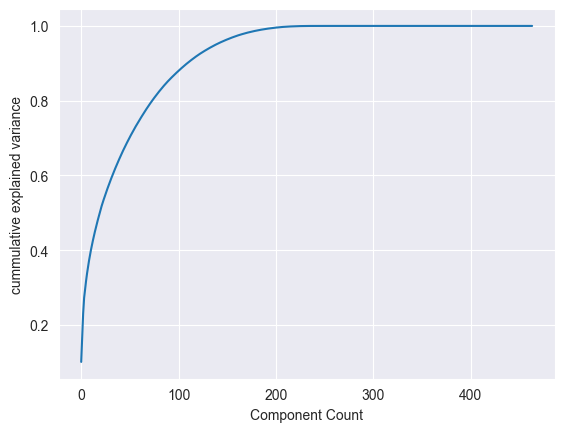

In [18]:
scaler = StandardScaler().fit(X)
Xs = scaler.transform(X)
pca = PCA().fit(Xs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component Count')
plt.ylabel('cummulative explained variance')
plt.show()

In [19]:
'''
n_components = 0.95
random_state = 69

# Daten vorbereiten
num_df = df_main.select_dtypes(include=['float64', 'int64'])
num_df = num_df.drop(columns=['smurf_flag'])  # smurf_flag is basically y_test

# smurf_score separat behandeln
base_features = [col for col in num_df.columns.tolist() if col != 'smurf_score']
X = num_df

X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)
X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]

# Modell-Container
models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
}

results = {}

# Modelle durchlaufen
for name, model in models.items():
    # Preprocessing-Pipeline: PCA auf alle außer smurf_score
    preprocessor = ColumnTransformer([
        ('pca_pipeline', make_pipeline(StandardScaler(), PCA(n_components=n_components)), base_features)
    ], remainder='passthrough')  # smurf_score bleibt erhalten

    pipe = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])

    # Train & Predict
    pipe.fit(X_train)
    y_train = pipe.predict(X_train)
    y_test = pipe.predict(X_test)

    results[f"{name}_Train"] = (y_train == -1).astype(int)
    results[f"{name}_Test"] = (y_test == -1).astype(int)

# Majority Vote
vote_train = (results["IsolationForest_Train"] + results["OneClassSVM_Train"] + results["LocalOutlierFactor_Train"]) >= 2
vote_test = (results["IsolationForest_Test"] + results["OneClassSVM_Test"] + results["LocalOutlierFactor_Test"]) >= 2

# Ergebnis-DataFrames
train_df = pd.DataFrame({
    "IF": results["IsolationForest_Train"],
    "SVM": results["OneClassSVM_Train"],
    "LOF": results["LocalOutlierFactor_Train"],
    "MajorityVote": vote_train.astype(int),
    "Dataset": "Train"
}, index=X_train.index)

test_df = pd.DataFrame({
    "IF": results["IsolationForest_Test"],
    "SVM": results["OneClassSVM_Test"],
    "LOF": results["LocalOutlierFactor_Test"],
    "MajorityVote": vote_test.astype(int),
    "Dataset": "Test"
}, index=X_test.index)

# Vergleich & Auswertung
comparison_df = pd.concat([train_df, test_df]).reset_index(drop=True)
majority_vote_summary = comparison_df.groupby("Dataset")["MajorityVote"].sum().to_frame(name="Sum_MajorityVotes")

train_size = comparison_df[comparison_df["Dataset"] == "Train"].shape[0]
test_size = comparison_df[comparison_df["Dataset"] == "Test"].shape[0]

train_ratio = majority_vote_summary.loc["Train", "Sum_MajorityVotes"] / train_size
test_ratio = majority_vote_summary.loc["Test", "Sum_MajorityVotes"] / test_size

print("Anteil Ausreißer im Training:", round(train_ratio, 8))
print("Anteil Ausreißer im Test:    ", round(test_ratio, 8))
'''

'\nn_components = 0.95\nrandom_state = 69\n\n# Daten vorbereiten\nnum_df = df_main.select_dtypes(include=[\'float64\', \'int64\'])\nnum_df = num_df.drop(columns=[\'smurf_flag\'])  # smurf_flag is basically y_test\n\n# smurf_score separat behandeln\nbase_features = [col for col in num_df.columns.tolist() if col != \'smurf_score\']\nX = num_df\n\nX_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)\nX_train = X.loc[X_train_idx]\nX_test = X.loc[X_test_idx]\n\n# Modell-Container\nmodels = {\n    \'IsolationForest\': IsolationForest(contamination=\'auto\', random_state=random_state),\n    \'OneClassSVM\': OneClassSVM(nu=0.05, kernel=\'rbf\', gamma=\'scale\'),\n    \'LocalOutlierFactor\': LocalOutlierFactor(n_neighbors=20, contamination=\'auto\', novelty=True)\n}\n\nresults = {}\n\n# Modelle durchlaufen\nfor name, model in models.items():\n    # Preprocessing-Pipeline: PCA auf alle außer smurf_score\n    preprocessor = ColumnTransformer([\n        (\'

In [20]:
'''
n_components=0.95
random_state = 69

num_df = df_main.select_dtypes(include=['float64','int64'])
num_df = num_df.drop(columns=['smurf_flag'])
X = num_df

X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)

X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]

def AutoEncoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)

    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(Adam(learning_rate=0.001), loss='mse')
    return autoencoder

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

pca_s = PCA(n_components=n_components)
X_train_p = pca_s.fit_transform(X_train_s)
X_test_p = pca_s.transform(X_test_s)

autoencoder = AutoEncoder(X_train_p.shape[1])
autoencoder.fit(X_train_p, X_train_p, epochs=30, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

train_reconstruction_loss = autoencoder.predict(X_train_p)
test_reconstruction_loss = autoencoder.predict(X_test_p)

train_mse = np.mean(np.square(X_train_p - train_reconstruction_loss), axis=1)
test_mse = np.mean(np.square(X_test_p - test_reconstruction_loss), axis=1)

threshold = np.percentile(train_mse, 95)

y_train_autoencoder = (train_mse > threshold).astype(int)
y_test_autoencoder = (test_mse > threshold).astype(int)


models = {
    'IsolationForest': IsolationForest(contamination='auto', random_state=random_state),
    'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale'),
    'LocalOutlierFactor': LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)
}

results = {
    "AutoEncoder_Train": y_train_autoencoder,
    "AutoEncoder_Test": y_test_autoencoder
}

for name, model in models.items():
    pipe = make_pipeline(
        StandardScaler(),
        PCA(n_components),
        model
    )

    pipe.fit(X_train)
    y_train = pipe.predict(X_train)
    y_test = pipe.predict(X_test)

    results[f"{name}_Train"] = (y_train == -1).astype(int)
    results[f"{name}_Test"] = (y_test == -1).astype(int)

vote_train = (
    results["IsolationForest_Train"] +
    results["OneClassSVM_Train"] +
    results["LocalOutlierFactor_Train"] +
    results["AutoEncoder_Train"]
    ) >= 2
vote_test = (
    results["IsolationForest_Test"] +
    results["OneClassSVM_Test"] +
    results["LocalOutlierFactor_Test"] +
    results["AutoEncoder_Test"]
    ) >= 2

train_df = pd.DataFrame({
    "IF": results["IsolationForest_Train"],
    "SVM": results["OneClassSVM_Train"],
    "LOF": results["LocalOutlierFactor_Train"],
    "AE": results["AutoEncoder_Train"],
    "MajorityVote": vote_train.astype(int),
    "Dataset": "Train"
}, index=X_train.index)

test_df = pd.DataFrame({
    "IF": results["IsolationForest_Test"],
    "SVM": results["OneClassSVM_Test"],
    "LOF": results["LocalOutlierFactor_Test"],
    "AE": results["AutoEncoder_Test"],
    "MajorityVote": vote_test.astype(int),
    "Dataset": "Test"
}, index=X_test.index)

comparison_df = pd.concat([train_df, test_df]).reset_index(drop=True)

majority_vote_summary = comparison_df.groupby("Dataset")["MajorityVote"].sum().to_frame(name="Sum_MajorityVotes")

train_size = comparison_df[comparison_df["Dataset"] == "Train"].shape[0]
test_size = comparison_df[comparison_df["Dataset"] == "Test"].shape[0]

train_ratio = majority_vote_summary.loc["Train", "Sum_MajorityVotes"] / train_size
test_ratio = majority_vote_summary.loc["Test", "Sum_MajorityVotes"] / test_size

print("Anteil Ausreißer im Training:", round(train_ratio, 8))
print("Anteil Ausreißer im Test:    ", round(test_ratio, 8))
'''

'\nn_components=0.95\nrandom_state = 69\n\nnum_df = df_main.select_dtypes(include=[\'float64\',\'int64\'])\nnum_df = num_df.drop(columns=[\'smurf_flag\'])\nX = num_df\n\nX_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=random_state)\n\nX_train = X.loc[X_train_idx]\nX_test = X.loc[X_test_idx]\n\ndef AutoEncoder(input_dim):\n    input_layer = Input(shape=(input_dim,))\n    encoded = Dense(32, activation=\'relu\')(input_layer)\n    encoded = Dense(16, activation=\'relu\')(encoded)\n    encoded = Dense(8, activation=\'relu\')(encoded)\n\n    decoded = Dense(16, activation=\'relu\')(encoded)\n    decoded = Dense(32, activation=\'relu\')(decoded)\n    output_layer = Dense(input_dim, activation=\'linear\')(decoded)\n\n    autoencoder = Model(input_layer, output_layer)\n    autoencoder.compile(Adam(learning_rate=0.001), loss=\'mse\')\n    return autoencoder\n\nscaler = StandardScaler()\nX_train_s = scaler.fit_transform(X_train)\nX_test_s = scaler.transform(X_test

In [21]:
'''n_components=0.95

num_df = df_main.select_dtypes(include=['float64','int64'])
X = num_df

X_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=42)

X_train = X.loc[X_train_idx]
X_test = X.loc[X_test_idx]


pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components),
    IsolationForest(contamination='auto', random_state=20)
)

pipe.fit(X_train)
y_train = pipe.predict(X_train)
y_test = pipe.predict(X_test)

df_main.loc[X_train.index, 'isSmurfTrain'] = (y_train == -1).astype(int)
df_main.loc[X_test.index, 'isSmurfTest'] = (y_test == -1).astype(int)

print("Anteil Ausreißer im Training:",  (y_train==-1).mean())
print("Anteil Ausreißer im Test:    ",  (y_test ==-1).mean())
'''

'n_components=0.95\n\nnum_df = df_main.select_dtypes(include=[\'float64\',\'int64\'])\nX = num_df\n\nX_train_idx, X_test_idx = train_test_split(X.index, test_size=0.2, random_state=42)\n\nX_train = X.loc[X_train_idx]\nX_test = X.loc[X_test_idx]\n\n\npipe = make_pipeline(\n    StandardScaler(),\n    PCA(n_components),\n    IsolationForest(contamination=\'auto\', random_state=20)\n)\n\npipe.fit(X_train)\ny_train = pipe.predict(X_train)\ny_test = pipe.predict(X_test)\n\ndf_main.loc[X_train.index, \'isSmurfTrain\'] = (y_train == -1).astype(int)\ndf_main.loc[X_test.index, \'isSmurfTest\'] = (y_test == -1).astype(int)\n\nprint("Anteil Ausreißer im Training:",  (y_train==-1).mean())\nprint("Anteil Ausreißer im Test:    ",  (y_test ==-1).mean())\n'